In [1]:
import glob

import csv
import statistics
import json
import math
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from pingouin import mwu
import pylab as py
from scipy.stats import pearsonr, ttest_ind, f_oneway, kruskal, tukey_hsd, mannwhitneyu, shapiro
import xlsxwriter
#import statsmodels.api as sm

Settings for data analysis: 

In [2]:
verbose  = False

Statistics functions:

In [3]:
def stats(data):
    '''Basic statistics. The statistics module doen not adequately handle 
    integer data'''
    mean = sum(data)/len(data)  #mean of dataset 
    sosq = sum([(i - mean)**2 for i in data])    #sum of squares
    var = sosq/(len(data)-1)    #variance of dataset
    stdev = math.sqrt(var)      #standard deviation
    med = statistics.median(data)
    return mean, stdev, med

In [4]:
def t_test_2sample(data1, data2, name1, name2):
    '''returns APA style report for 2 sample T-test. Independant samples
    with equivalent variance are assumed'''
    mean1, stdev1, med = stats(data1)
    mean2, stdev2, med = stats(data2)
    t = ttest_ind(data1, data2)
    print('null hypothesis: samples are from populations with identical expected averages')
    print(f'{name1} t-test against {name2}:')
    print(f'{name1} (M={round(mean1,1)}, SD={round(stdev1,2)})')
    print(f'{name2} (M={round(mean2,1)}, SD={round(stdev2,2)})')
    print(f'Independant T-test results t({len(data1)-1+len(data2)-1}) = {round(t[0],3)}, p = {round(t[1],3)}')
    if t[1] > .001:
        print(f'Independant T-test results t({len(data1)-1+len(data2)-1}) = {round(t[0],3)}, p = {round(t[1],3)}')
        print('the null hypothesis is not rejected')
    else:
        print(f'Independant T-test results t({len(data1)-1+len(data2)-1}) = {round(t[0],3)}, p < .001')
        print(f'With p < .001 the null hypothesis is rejected')


In [5]:
def mann_whitney(data1, data2, name1, name2):
    '''returns APA style report for 2 sample T-test. Independant samples
    with equivalent variance are assumed'''
    mean1, stdev1, med1 = stats(data1)
    mean2, stdev2, med2 = stats(data2)
    u = mannwhitneyu(data1, data2)
    u2 = mwu(avgs_SRWC_BR, avgs_SRWC_ACT)
    rbc = round(u2['RBC'][0],3)
    print('null hypothesis: samples are from populations with identical distributions')
    print(f'{name1} Mann-Whitney U test against {name2}:')
    print(f'{name1} (Mdn = {round(med1,1)}, N1 = {len(data1)})')
    print(f'{name2} (Mdn = {round(med2,1)}, N2 = {len(data2)})')
    if u[1] <= .05 and u[1] > .001:
        print(f'Mann Whitney test U(N1 = {len(data1)}, N2 = {len(data2)}) = {u[0]}, p = {round(u[1],3)}')
        print(f'With a p value of {round(u[1],3)} the null hypothesis is rejected')
        print(f'The Rank Biserial Correlation (RBC) effect size is {rbc} ')
    elif u[1] <= .001:
        print(f'Mann Whitney test U(N1 = {len(data1)}, N2 = {len(data2)}) = {u[0]}, p = {round(u[1],3)}')
        print(f'With a p < .001 the null hypothesis is rejected')
        print(f'The Rank Biserial Correlation (RBC) effect size is {rbc} ')
    else:
        print(f'Mann Whitney test U(N1 = {len(data1)}, N2 = {len(data2)}) = {u[0]}, p = {round(u[1],3)}')
        print(f'With p = {round(u[1],3)} the null hypothesis is not rejected')

    


In [6]:
def one_way_anova(*args):
    f = f_oneway(*args)
    BG_df = len(args) - 1
    WG_df = sum([len(a) for a in args]) - len(args)
    if f[1] <= .05 and f[1] > .001:
        print('There is a significant effect of the simulation setting on the number') 
        print(f'of pilots that succesfully complete the CT program [F({BG_df}, {WG_df}) = {round(f[0],1)}, p = {round(f[1],3)})]')
        print('performing post hoc test (Tukey HSD)')
        result = tukey_hsd(*args)
        print(result)
    elif f[1] <= .001:
        print('There is a significant effect of the simulation setting on the number') 
        print(f'of pilots that succesfully complete the CT program [F({BG_df}, {WG_df}) = {round(f[0],1)}, p < .001)]')
        print('performing post hoc test (Tukey HSD)')
        result = tukey_hsd(*args)
        print(result)
    else:
        print(f'no significant differences between the settings were found [F({BG_df}, {WG_df}) = {round(f[0],1)}, p = ns]')

In [7]:
def kruskal_wallis(*args):
    h = kruskal(*args)
    BG_df = len(args) - 1
    if h[1] <= .05 and h[1] > .001:
        print('There is a significant effect of the simulation setting on the number') 
        print(f'of pilots that succesfully complete the CT program [H({BG_df}) = {round(h[0],1)}, p = {round(h[1],3)})]')
        print('performing post hoc test (Tukey HSD)')
        result = tukey_hsd(*args)
        print(result)
    elif h[1] <= .001:
        print('There is a significant effect of the simulation setting on the number') 
        print(f'of pilots that succesfully complete the CT program [H({BG_df}) = {round(h[0],1)}, p < .001)]')
        print('performing post hoc test (Tukey HSD)')
        result = tukey_hsd(*args)
        print(result)
    else:
        print(f'no significant differences between the settings were found [H({BG_df}) = {round(h[0],1)}, p = ns)]')

In [8]:
def agregate(data):
    avgs = []
    for i in range(len(data)):
        avgs.append(min(data[i]))
    return avgs

In [9]:
def agregate_min(data):
    avgs = []
    for i in range(len(data)):
        avgs.append(min(data[i]))
    return avgs

In [10]:
def boxplot(data, legend, ylabel_='No. of Pilots', title_='Breakdown of CT Completion for SR-WC', save_='anova_post_hoc.jpg'):
        fig, ax = plt.subplots()
        boxes = [d for d in data]
        bp = ax.boxplot(boxes, patch_artist=True)
        plt.ylim(top=20, bottom=0)
        plt.yticks(np.arange(0, 20, 2.0))
        #ax.set(xlabel='osf setting'.format('Arial'))
        ax.set(ylabel=ylabel_.format('Arial'))
        ax.set_title(title_.format('Arial'))
        ax.set_xticklabels([l for l in legend])
        for box in bp['boxes']:
            box.set( color='k', linewidth=0.5)
            box.set( facecolor = 'w' )
        for flier in bp['fliers']:
            flier.set(marker='o', color='r')#, alpha=0.5
        fig.savefig(save_, dpi=300)

Import Sets for missions, missions in ACT and pilots:

In [11]:
M = {}
M_a = {}
P = {}

with open('C:/Users/Coen/Documents/GitHub/CT_schedule/data/missions.csv', mode='r',encoding='utf-8-sig') as f:
    reader = csv.reader(f)
    for row in reader:
        M[row[0]] = np.genfromtxt(row[1:10], dtype='int')

with open('C:/Users/Coen/Documents/GitHub/CT_schedule/data/missions_alternativeCT.csv', mode='r',encoding='utf-8-sig') as f:
    reader = csv.reader(f)
    for row in reader:
        M_a[row[0]] = np.genfromtxt(row[1:10], dtype='int')
        
with open('C:/Users/Coen/Documents/GitHub/CT_schedule/data/pilots.csv', mode='r',encoding='utf-8-sig') as f:
    reader = csv.reader(f)
    for row in reader:
        P[row[0]] = np.genfromtxt(row[1:6], dtype='int')

Function check_CT filters the pilot history for a specific run and sorts in number of completed CT programs. 

In [72]:
def check_CT(hist, hist_sim, missions, pilots):
    completions = np.full((18,6),0)
    i = 0
    for p in P:
        total_sorties_p = sum(hist[p].values())
        if P[p][4] > 0:
            check_min = total_sorties_p >= 41
            check_desired = total_sorties_p >= 69
        else:
            check_min = total_sorties_p >= 58
            check_desired = total_sorties_p >= 73
        count = 0
        for m in missions:     
            if hist[p][m] - missions[m][P[p][0]] < 0:
                count += 1
                if verbose:
                    print(f'min LIVE failed for pilot {p} on mission {m}')
        if count <= 0 and check_min:
            completions[i][0] = 1

        count = 0
        for m in missions:
            if hist[p][m] - missions[m][P[p][1]] < 0:
                count += 1
                if verbose:
                    print(f'desired LIVE failed for pilot {p} on mission {m}')
        if count <= 0 and check_desired:
            completions[i][1] = 1
        else:
            print(f'live {p}')
            print(count)
        #------ SIM ---------    
        total_sorties_p_sim = sum(hist_sim[p].values())
        if P[p][4] > 0:
            check_min = total_sorties_p_sim >= 37
            check_desired = total_sorties_p_sim >= 53
        else:
            check_min = total_sorties_p_sim >= 42
            check_desired = total_sorties_p_sim >= 72
        count = 0
        for m in missions:     
            if hist_sim[p][m] - missions[m][P[p][2]] < 0:
                count += 1
                if verbose:
                    print(f'min SIM failed for pilot {p} on mission {m}')
        if count <= 0 and check_min:
            completions[i][2] = 1

        count = 0
        for m in missions:
            if hist_sim[p][m] - missions[m][P[p][3]] < 0:
                count += 1
                if verbose:
                    print(f'desired SIM failed for pilot {p} on mission {m}')
        if count <= 0 and check_desired:
            completions[i][3] = 1
        else:
            print(f'sim {p}')
            print(count)
       #print(f'{p}')
        #print(count) #use print function to check number of failed desired CT sorties per pilot 
    #print('end run')
        if completions[i][0] + completions[i][2] == 2:
            completions[i][4] = 1
        if completions[i][1] + completions[i][3] == 2:
            completions[i][5] = 1    
        i+=1
    return completions
    

In [13]:
def importer(run, missions, pilots, i):
    with open(f'{run}/run_{i}_CTresults_live.txt') as f:
        hist = json.load(f)
    with open(f'{run}/run_{i}_CTresults_sim.txt') as g:
        hist_sim = json.load(g)
        completions = check_CT(hist, hist_sim, missions, pilots)
    return completions

In [14]:
def run_analysis(run, missions, pilots):
    header = ['min_live', 'des_live', 'min_sim', 'des_sim', 'min_ct', 'des_ct']
    names = pilots.keys()
    run_summary = np.full((30,6),0)
    with pd.ExcelWriter(f'{run}.xlsx') as writer:
        for i in range(30):
            completions = importer(run, missions, pilots, i)
            for j in range(6):
                run_summary[i][j] = sum(completions[:,j])          
            df = pd.DataFrame(completions,
                             index=names,
                             columns=header)
            df.to_excel(writer, sheet_name=f'run_{i}')
        df_sum = pd.DataFrame(run_summary,
                             columns=header)
        df_sum.to_excel(writer, sheet_name='run_summary')
    return run_summary

Write data from json import to data vars for each setting

In [15]:
data_SRWC_ACT = run_analysis('SR-WC - alternate CT', M_a, P)
data_SRWC_BR = run_analysis('SR-WC - base osf', M, P)
data_SRWC_HR = run_analysis('SR-WC - high osf', M, P)
data_SRWC_LR = run_analysis('SR-WC - low osf', M, P)
data_MRWC = run_analysis('MR-WC', M, P)
data_DR = run_analysis('DR', M, P)
data_SRMC = run_analysis('SR-MC', M, P)


C:\Users\Coen\AppData\Roaming\Python\Python38\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [75]:
data_SRWC_BR = run_analysis('SR-WC - base osf', M, P)

sim Wolfman
1
sim Chipper
1
sim Loggins
1
live Stinger
1
sim Sundown
2
sim Stinger
1
live Hollywood
1
live Maverick
2
live Stinger
2
live Jester
2
live Cougar
1
live Maverick
1
live Cougar
1
sim Wolfman
1
live Chipper
1
live Iceman
1
live Viper
1
sim Viper
1
live Sundown
1
sim Charlie
1
live Chipper
1
sim Loggins
1
live Maverick
1
sim Stinger
1
live Wolfman
1
live Kenny
2
sim Kenny
2
sim Loggins
1
live Zone
1
sim Slider
1
live Iceman
1
live Stinger
4
sim Stinger
3
live Jester
2
sim Jester
3
live Charlie
2
live Chipper
1
sim Chipper
2
sim Loggins
1
live Hollywood
1
sim Cougar
1
sim Merlin
1
live Chipper
1
live Sundown
2
sim Jester
1
live Hollywood
2
sim Wolfman
1
live Charlie
1
live Chipper
1
sim Iceman
1
live Sundown
1
sim Sundown
1
live Stinger
2
sim Stinger
3
live Jester
1
sim Jester
3
sim Slider
3
sim Kenny
1
live Zone
1
live Iceman
1
sim Chipper
1
sim Kenny
1
live Loggins
5
sim Loggins
2
live Iceman
1
sim Jester
2
live Charlie
1
live Loggins
1
sim Zone
1
sim Viper
1
sim Stinger
1
l

In [16]:
avgs_SRWC_ACT = data_SRWC_ACT[:,5]
avgs_SRWC_BR = data_SRWC_BR[:,5]
avgs_SRWC_HR = data_SRWC_HR[:,5]
avgs_SRWC_LR = data_SRWC_LR[:,5]
avgs_MRWC = data_MRWC[:,5]
avgs_DR = data_DR[:,5]
avgs_SRMC = data_SRMC[:,5]
   
#plt.boxplot(avgs_SRWC_ACT, labels=['SR-WC - alternative CT'])    

In [17]:
avgs_min_SRWC_ACT = data_SRWC_ACT[:,4]
avgs_min_SRWC_BR = data_SRWC_BR[:,4]
avgs_min_SRWC_HR = data_SRWC_HR[:,4]
avgs_min_SRWC_LR = data_SRWC_LR[:,4]
avgs_min_MRWC = data_MRWC[:,4]
avgs_min_DR = data_DR[:,4]
avgs_min_SRMC = data_SRMC[:,4]

In [47]:
for i in avgs_SRMC:
    print(i)

3
0
5
3
7
1
2
3
8
3
4
4
5
5
4
4
3
2
5
5
1
6
5
4
7
0
5
3
4
6


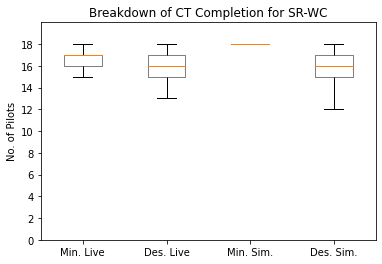

In [19]:
boxplot([data_SRWC_BR[0:30,0], data_SRWC_BR[0:30,1], data_SRWC_BR[0:30,2], data_SRWC_BR[0:30,3]], ['Min. Live', 'Des. Live', 'Min. Sim.', 'Des. Sim.'])

# The results of the total desired CT completion is depicted in the following boxplot:

Comparison for the schedule regeneration setting:

There is a significant effect of the simulation setting on the number
of pilots that succesfully complete the CT program [H(3) = 90.1, p < .001)]
performing post hoc test (Tukey HSD)
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     10.433    -0.000     9.078    11.788
 (0 - 2)      0.500     0.771    -0.855     1.855
 (0 - 3)     10.000    -0.000     8.645    11.355
 (1 - 0)    -10.433    -0.000   -11.788    -9.078
 (1 - 2)     -9.933    -0.000   -11.288    -8.578
 (1 - 3)     -0.433     0.838    -1.788     0.922
 (2 - 0)     -0.500     0.771    -1.855     0.855
 (2 - 1)      9.933    -0.000     8.578    11.288
 (2 - 3)      9.500    -0.000     8.145    10.855
 (3 - 0)    -10.000    -0.000   -11.355    -8.645
 (3 - 1)      0.433     0.838    -0.922     1.788
 (3 - 2)     -9.500    -0.000   -10.855    -8.145

setting SR-WC (Mdn = 14.0)
setting SR-MC (Mdn = 4.0)
setting MR-WC (Mdn = 14.0)
setting DR (Mdn = 

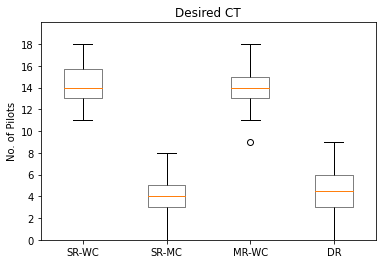

In [55]:
kruskal_wallis(avgs_SRWC_BR, avgs_SRMC, avgs_MRWC, avgs_DR)
mean0, stdev0, med0 = stats(avgs_SRWC_BR)
mean1, stdev1, med1 = stats(avgs_SRMC)
mean2, stdev2, med2 = stats(avgs_MRWC)
mean3, stdev3, med3 = stats(avgs_DR)
print(f'setting SR-WC (Mdn = {med0})')
print(f'setting SR-MC (Mdn = {med1})')
print(f'setting MR-WC (Mdn = {med2})')
print(f'setting DR (Mdn = {med3})')
boxplot([avgs_SRWC_BR, avgs_SRMC, avgs_MRWC, avgs_DR], ['SR-WC', 'SR-MC', 'MR-WC', 'DR'], title_='Desired CT')

In [52]:
one_way_anova(avgs_SRWC_BR, avgs_SRMC, avgs_MRWC, avgs_DR)

There is a significant effect of the simulation setting on the number
of pilots that succesfully complete the CT program [F(3, 116) = 245.6, p < .001)]
performing post hoc test (Tukey HSD)
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     10.433    -0.000     9.078    11.788
 (0 - 2)      0.500     0.771    -0.855     1.855
 (0 - 3)     10.000    -0.000     8.645    11.355
 (1 - 0)    -10.433    -0.000   -11.788    -9.078
 (1 - 2)     -9.933    -0.000   -11.288    -8.578
 (1 - 3)     -0.433     0.838    -1.788     0.922
 (2 - 0)     -0.500     0.771    -1.855     0.855
 (2 - 1)      9.933    -0.000     8.578    11.288
 (2 - 3)      9.500    -0.000     8.145    10.855
 (3 - 0)    -10.000    -0.000   -11.355    -8.645
 (3 - 1)      0.433     0.838    -0.922     1.788
 (3 - 2)     -9.500    -0.000   -10.855    -8.145



In [64]:
mean0, stdev0, med0 = stats(avgs_SRWC_BR)
mean1, stdev1, med1 = stats(avgs_SRMC)
mean2, stdev2, med2 = stats(avgs_MRWC)
mean3, stdev3, med3 = stats(avgs_DR)
print(f'setting SR-WC (M = {round(mean0,1)}, SD = {round(stdev0,2)})')
print(f'setting SR-MC (M = {round(mean1,1)}, SD = {round(stdev1,2)})')
print(f'setting MR-WC (M = {round(mean2,1)}, SD = {round(stdev2,2)})')
print(f'setting DR (M = {round(mean3,1)}, SD = {round(stdev3,2)})')

setting SR-WC (M = 14.3, SD = 1.97)
setting SR-MC (M = 3.9, SD = 1.97)
setting MR-WC (M = 13.8, SD = 1.88)
setting DR (M = 4.3, SD = 2.22)


osf base rate setting:

no significant differences between the settings were found [F(2, 87) = 2.1, p = ns]


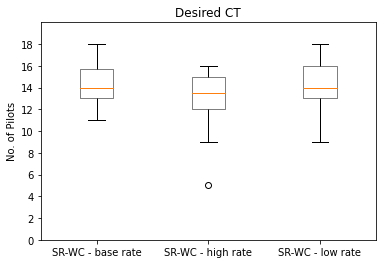

In [67]:
one_way_anova(avgs_SRWC_BR, avgs_SRWC_HR, avgs_SRWC_LR)
boxplot([avgs_SRWC_BR, avgs_SRWC_HR, avgs_SRWC_LR], ['SR-WC - base rate', 'SR-WC - high rate', 'SR-WC - low rate'], title_='Desired CT')

Effect of Ct structure of CT completion:

null hypothesis: samples are from populations with identical expected averages
SR-WC - regular CT t-test against SR-WC - alternative CT:
SR-WC - regular CT (M=14.3, SD=1.97)
SR-WC - alternative CT (M=15.8, SD=1.3)
Independant T-test results t(58) = -3.321, p = 0.002
Independant T-test results t(58) = -3.321, p = 0.002
the null hypothesis is not rejected


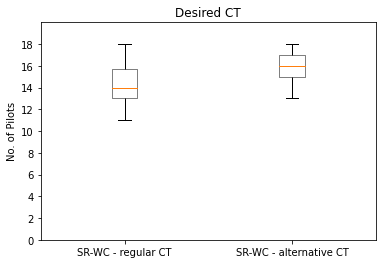

In [69]:
t_test_2sample(avgs_SRWC_BR, avgs_SRWC_ACT, 'SR-WC - regular CT', 'SR-WC - alternative CT')
boxplot([avgs_SRWC_BR, avgs_SRWC_ACT], ['SR-WC - regular CT', 'SR-WC - alternative CT'], title_='Desired CT')

# Same but for the minimum CT:

There is a significant effect of the simulation setting on the number
of pilots that succesfully complete the CT program [H(3) = 76.4, p < .001)]
performing post hoc test (Tukey HSD)
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      4.200     0.000     2.839     5.561
 (0 - 2)      0.533     0.737    -0.828     1.895
 (0 - 3)      6.900    -0.000     5.539     8.261
 (1 - 0)     -4.200     0.000    -5.561    -2.839
 (1 - 2)     -3.667     0.000    -5.028    -2.305
 (1 - 3)      2.700     0.000     1.339     4.061
 (2 - 0)     -0.533     0.737    -1.895     0.828
 (2 - 1)      3.667     0.000     2.305     5.028
 (2 - 3)      6.367    -0.000     5.005     7.728
 (3 - 0)     -6.900    -0.000    -8.261    -5.539
 (3 - 1)     -2.700     0.000    -4.061    -1.339
 (3 - 2)     -6.367    -0.000    -7.728    -5.005

setting SR-WC (Mdn = 17.0)
setting SR-MC (Mdn = 12.0)
setting MR-WC (Mdn = 16.0)
setting DR (Mdn =

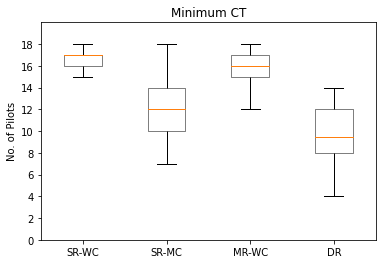

In [56]:
kruskal_wallis(avgs_min_SRWC_BR, avgs_min_SRMC, avgs_min_MRWC, avgs_min_DR)
mean0, stdev0, med0 = stats(avgs_min_SRWC_BR)
mean1, stdev1, med1 = stats(avgs_min_SRMC)
mean2, stdev2, med2 = stats(avgs_min_MRWC)
mean3, stdev3, med3 = stats(avgs_min_DR)
print(f'setting SR-WC (Mdn = {med0})')
print(f'setting SR-MC (Mdn = {med1})')
print(f'setting MR-WC (Mdn = {med2})')
print(f'setting DR (Mdn = {med3})')
boxplot([avgs_min_SRWC_BR, avgs_min_SRMC, avgs_min_MRWC, avgs_min_DR], ['SR-WC', 'SR-MC', 'MR-WC', 'DR'], title_='Minimum CT')

In [65]:
one_way_anova(avgs_min_SRWC_BR, avgs_min_SRMC, avgs_min_MRWC, avgs_min_DR)

There is a significant effect of the simulation setting on the number
of pilots that succesfully complete the CT program [F(3, 116) = 77.5, p < .001)]
performing post hoc test (Tukey HSD)
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      4.200     0.000     2.839     5.561
 (0 - 2)      0.533     0.737    -0.828     1.895
 (0 - 3)      6.900    -0.000     5.539     8.261
 (1 - 0)     -4.200     0.000    -5.561    -2.839
 (1 - 2)     -3.667     0.000    -5.028    -2.305
 (1 - 3)      2.700     0.000     1.339     4.061
 (2 - 0)     -0.533     0.737    -1.895     0.828
 (2 - 1)      3.667     0.000     2.305     5.028
 (2 - 3)      6.367    -0.000     5.005     7.728
 (3 - 0)     -6.900    -0.000    -8.261    -5.539
 (3 - 1)     -2.700     0.000    -4.061    -1.339
 (3 - 2)     -6.367    -0.000    -7.728    -5.005



In [66]:
mean0, stdev0, med0 = stats(avgs_min_SRWC_BR)
mean1, stdev1, med1 = stats(avgs_min_SRMC)
mean2, stdev2, med2 = stats(avgs_min_MRWC)
mean3, stdev3, med3 = stats(avgs_min_DR)
print(f'setting SR-WC (M = {round(mean0,1)}, SD = {round(stdev0,2)})')
print(f'setting SR-MC (M = {round(mean1,1)}, SD = {round(stdev1,2)})')
print(f'setting MR-WC (M = {round(mean2,1)}, SD = {round(stdev2,2)})')
print(f'setting DR (M = {round(mean3,1)}, SD = {round(stdev3,2)})')

setting SR-WC (M = 16.6, SD = 0.97)
setting SR-MC (M = 12.4, SD = 2.82)
setting MR-WC (M = 16.1, SD = 1.39)
setting DR (M = 9.7, SD = 2.35)


In [29]:
mann_whitney(avgs_min_SRWC_BR, avgs_min_SRMC, 'SR-WC', 'SR-MC')

null hypothesis: samples are from populations with identical distributions
SR-WC Mann-Whitney U test against SR-MC:
SR-WC (Mdn = 17.0, N1 = 30)
SR-MC (Mdn = 12.0, N2 = 30)
Mann Whitney test U(N1 = 30, N2 = 30) = 808.0, p = 0.0
With a p < .001 the null hypothesis is rejected
The Rank Biserial Correlation (RBC) effect size is 0.436 


In [30]:
mann_whitney(avgs_min_SRWC_BR, avgs_min_DR, 'SR-WC', 'DR')

null hypothesis: samples are from populations with identical distributions
SR-WC Mann-Whitney U test against DR:
SR-WC (Mdn = 17.0, N1 = 30)
DR (Mdn = 9.5, N2 = 30)
Mann Whitney test U(N1 = 30, N2 = 30) = 900.0, p = 0.0
With a p < .001 the null hypothesis is rejected
The Rank Biserial Correlation (RBC) effect size is 0.436 


In [31]:
mann_whitney(avgs_min_SRWC_BR, avgs_min_MRWC, 'SR-WC', 'MR-WC')

null hypothesis: samples are from populations with identical distributions
SR-WC Mann-Whitney U test against MR-WC:
SR-WC (Mdn = 17.0, N1 = 30)
MR-WC (Mdn = 16.0, N2 = 30)
Mann Whitney test U(N1 = 30, N2 = 30) = 544.0, p = 0.153
With p = 0.153 the null hypothesis is not rejected


In [32]:
mann_whitney(avgs_min_MRWC, avgs_min_SRMC, 'MR-WC', 'SR-MC')

null hypothesis: samples are from populations with identical distributions
MR-WC Mann-Whitney U test against SR-MC:
MR-WC (Mdn = 16.0, N1 = 30)
SR-MC (Mdn = 12.0, N2 = 30)
Mann Whitney test U(N1 = 30, N2 = 30) = 772.5, p = 0.0
With a p < .001 the null hypothesis is rejected
The Rank Biserial Correlation (RBC) effect size is 0.436 


In [33]:
mann_whitney(avgs_min_MRWC, avgs_min_DR, 'MR-WC', 'DR')

null hypothesis: samples are from populations with identical distributions
MR-WC Mann-Whitney U test against DR:
MR-WC (Mdn = 16.0, N1 = 30)
DR (Mdn = 9.5, N2 = 30)
Mann Whitney test U(N1 = 30, N2 = 30) = 893.0, p = 0.0
With a p < .001 the null hypothesis is rejected
The Rank Biserial Correlation (RBC) effect size is 0.436 


no significant differences between the settings were found [F(2, 87) = 1.7, p = ns]


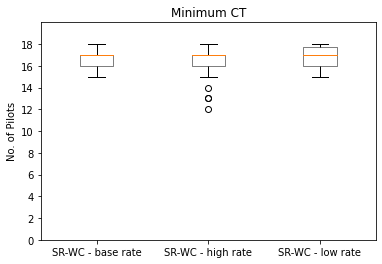

In [68]:
one_way_anova(avgs_min_SRWC_BR, avgs_min_SRWC_HR, avgs_min_SRWC_LR)
boxplot([avgs_min_SRWC_BR, avgs_min_SRWC_HR, avgs_min_SRWC_LR], ['SR-WC - base rate', 'SR-WC - high rate', 'SR-WC - low rate'], title_='Minimum CT')

null hypothesis: samples are from populations with identical distributions
SR-WC - regular CT Mann-Whitney U test against SR-WC - alternative CT:
SR-WC - regular CT (Mdn = 17.0, N1 = 30)
SR-WC - alternative CT (Mdn = 18.0, N2 = 30)
Mann Whitney test U(N1 = 30, N2 = 30) = 224.0, p = 0.0
With a p < .001 the null hypothesis is rejected
The Rank Biserial Correlation (RBC) effect size is 0.436 


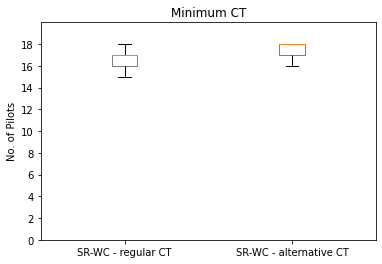

In [60]:
mann_whitney(avgs_min_SRWC_BR, avgs_min_SRWC_ACT, 'SR-WC - regular CT', 'SR-WC - alternative CT')
boxplot([avgs_min_SRWC_BR, avgs_min_SRWC_ACT], ['SR-WC - regular CT', 'SR-WC - alternative CT'], title_='Minimum CT')

# FMP data processing

In [37]:
def plot_FHR(data):
    print('Plot FHR data')

def plot_regen(data):
    print('Plot dynamic regen function')

In [38]:
def run_sampler(run_name):
    FHR_actualized = []
    waves_weather_cancel = []
    sortie_weather_cancel = []
    insuf_AC_cancel = []
    sortie_executed = []
    FT_FMP = []
    corrective_MX = {a: [] for a in ['1_small', '1_large', '2_large']}
    regen_ratio = []
    regen_period = []
    runtime = []
    for file in glob.glob(f'{run_name}\*_data.txt'):
        with open(file) as f:
            a = json.load(f)
            FHR_actualized.append(a["FHR_cummulative"])
            waves_weather_cancel.append(a["waves_weather_cancel"])
            insuf_AC_cancel.append(a["sortie_weather_cancel"])
            sortie_executed.append(a["insuf_AC_cancel"])
            corrective_MX['1_small'].append(a["corrective_MX"]["1_small"])
            corrective_MX['1_large'].append(a["corrective_MX"]["1_large"])
            corrective_MX['2_large'].append(a["corrective_MX"]["2_large"])
            FT_FMP = a["FT_FMP"]
            runtime.append(a["runtime_simulation"])
    data_FHR = np.empty([5, 365])
    for i in range(365):
        data = []
        for j in range(30):
            data.append(FHR_actualized[j][i])
        data_FHR[0][i] = max(data) - FT_FMP[i]
        data_FHR[1][i] = min(data) - FT_FMP[i]
        data_FHR[2][i] = sum(data)/len(data) - FT_FMP[i]
        data_FHR[3][i] = FT_FMP[i] - FT_FMP[i]
        data_FHR[4][i] = FT_FMP[i] - FT_FMP[i] - 113
    
    #plt.plot(FT_FMP, color='tab:red')
    plt.plot(data_FHR[0], color='gray', linestyle='dashdot') # max
    plt.plot(data_FHR[1], color='grey', linestyle='dashdot') # min
    plt.plot(data_FHR[2], color='tab:blue') # mean
    plt.plot(data_FHR[3], color='tab:red')
    plt.plot(data_FHR[4], color='tab:red', linestyle='dashdot')
    plt.ylim([-300,300])
    plt.plot
    
    #plt.plot([FT_FMP[i]/FT_FMP[i] for i in range(len(data_FHR))])
    
    return FHR_actualized, runtime

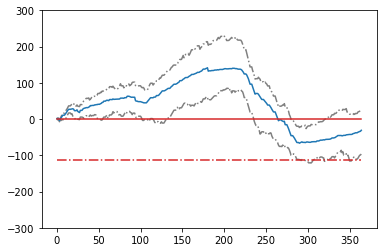

In [39]:
FHR_actualized = run_sampler('MR-WC')

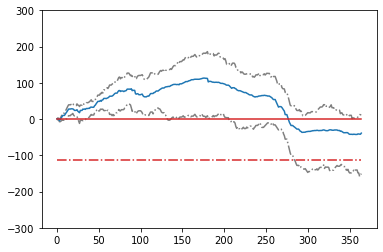

In [40]:
FHR_actualized = run_sampler('SR-WC - base osf')

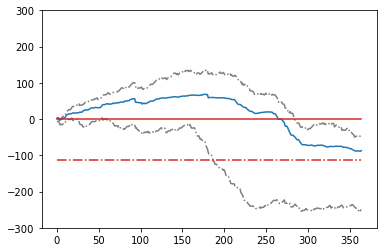

In [41]:
FHR_actualized = run_sampler('SR-WC - low osf')

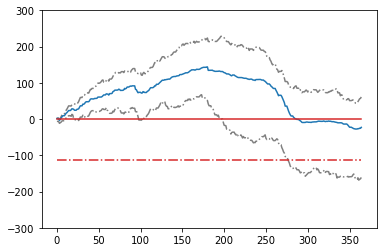

In [42]:
FHR_actualized = run_sampler('SR-WC - high osf')

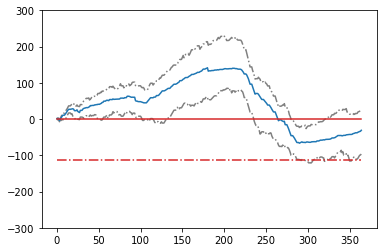

In [43]:
FHR_actualized = run_sampler('MR-WC')

2650.0
6324.0
9160.0
14001.0
16931.0
19793.0
23926.0
28257.0
31039.0
40941.0
44969.0
4834.0
48657.0
52320.0
54758.0
57677.0
61420.0
64750.0
66890.0
69396.0
74574.0
76771.0
7484.0
9924.0
11491.0
13982.0
21609.0
23190.0
24978.0
4143.0


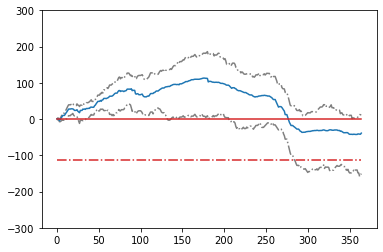

In [44]:
FHR_actualized, runtime = run_sampler('SR-WC - base osf')
for i in runtime:
    print(np.round(i))

In [45]:
print(data_FHR)

NameError: name 'data_FHR' is not defined